<a href="https://colab.research.google.com/github/kitamura-felipe/MC10-Metrics4ML/blob/master/Metrics4ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Magicians Corner x - Performance Metrics for Machine Learning

###by: Bradley J Erickson, MD PhD and Felipe Kitamura, MD MSc
*Copyright 2020

###See corresponding Radiology: AI article here:


Thanks to scikit-learn (https://scikit-learn.org/0.20/index.html)

# Classification Metrics

Classification models can be divided into:


1.   **Binary**: the model output is a single decimal number between 0 and 1. After applying a threshold, it will turn into 0 or 1.
2.   **Multiclass**: the model output is made of N decimal numbers (N is the number of classes). After applying a threshold, only one of the classes can be 1. The rest will be zero.
3.   **Multilabel**: the model output is made of N decimal numbers (N is the number of classes). After applying a threshold, any of the classes can be 0 or 1.

We will see examples where each case is appropriate.




In [0]:
# Cell 1

# First, we import the libraries we will use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, \
                            auc, \
                            precision_recall_curve, \
                            average_precision_score, \
                            roc_auc_score, \
                            confusion_matrix, \
                            accuracy_score, \
                            f1_score
from sklearn.utils.multiclass import unique_labels

## 1. Binary Classification

Let's supose we have a model that classifies an X-ray image into normal vs pneumonia.

In this case, the model output will be a decimal number somewhere between 0 and 1. As convention, we will define 0 as normal and 1 as pneumonia.

So, what do we do if, for a given X-ray, the model output (score) is 0.5? What if it's 0.3, or 0.9?

The first concept we need to cover is the **threshold**. The **threshold** is a cutoff value above which we say the result is 1. If the score is equal or less than the threshold, the result is 0.

Higher thresholds mean we will be too picky and undercall the diagnosis, but when we do it, we will be more confident.

Lower thresholds mean we will overcall the diagnosis and make sure we don't miss any real positive cases. However, by doing that, we will also call positive some negative cases.

Let's go through some examples. In this module we will not train any neural network. We've done the inference of a neural network on the test set and the result is in the scores.csv file.


In [76]:
# Cell 2

# Lets download the scores.csv file to calculate the metrics from it.

!wget https://raw.githubusercontent.com/kitamura-felipe/MC10-Metrics4ML/master/scores.csv -O scores.csv

--2020-05-22 02:00:18--  https://raw.githubusercontent.com/kitamura-felipe/MC10-Metrics4ML/master/scores.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9771 (9.5K) [text/plain]
Saving to: ‘scores.csv’

scores.csv          100%[===================>]   9.54K  --.-KB/s    in 0s      

2020-05-22 02:00:19 (74.7 MB/s) - ‘scores.csv’ saved [9771/9771]



In [77]:
# Cell 3

# Let's open this scores.csv file and undesrtand it's content

df = pd.read_csv('scores.csv')

print("Total number of rows (inferences on X-rays): " + str(len(df)))
print("We see the first 10 cases in this table.")

df.head(10)

Total number of rows (inferences on X-rays): 415
We see the first 10 cases in this table.


,y_pred,y_test
0,0.127696,0
1,0.009967,0
2,0.425055,1
3,0.051483,0
4,0.421962,0
5,0.373866,0
6,0.532961,0
7,0.000164,0
8,0.285637,1
9,0.320673,1


The first column is the index of the X-rays (here we only showed cases 0 to 9).

The **y_pred** column contains the predicted scores from our neural network for each X-ray.

The **y_test** column contains the grount truth for this test set, annotated by a radiologist.

Let's pick up a **threshold** of 0.5 and calculate how many right and wrong cases we have.

In [78]:
# Cell 4

threshold = 0.5

# How many cases the model said pneumonia (score > threshold) and the ground truth was pneumonia (1)

true_positives = ((df.y_pred > threshold) & (df.y_test == 1)).sum()

# How many cases the model said pneumonia (score > threshold) but the ground truth was normal (0)

false_positives = ((df.y_pred > threshold) & (df.y_test == 0)).sum()

# How many cases the model said normal (score <= threshold) and the ground truth was normal (0)

true_negatives = ((df.y_pred <= threshold) & (df.y_test == 0)).sum()

# How many cases the model said normal (score <= threshold) but the ground truth was pneumonia (1)

false_negatives = ((df.y_pred <= threshold) & (df.y_test == 1)).sum()

# Now let's print these values

print("True positives: " + str(true_positives))
print("False positives: " + str(false_positives))
print("True negatives: " + str(true_negatives))
print("False negatives: " + str(false_negatives))

True positives: 19
False positives: 8
True negatives: 358
False negatives: 30


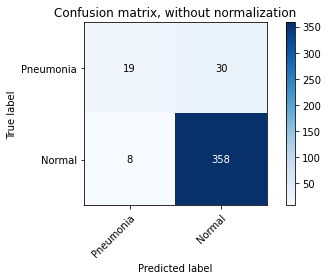

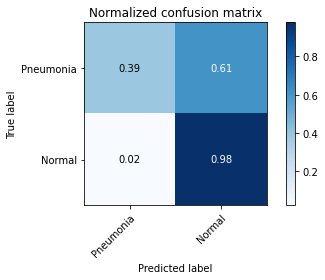

In [79]:
# Cell 5

# There is a nicer way to see these values. We call it confusion matrix.
# Don't worry about this name. The ideia is that it should make things less confusing

# We will plot a 2 x 2 table where the rows represent the ground truth
# and the columns represent the predictions

cm = np.array([[true_positives, false_negatives],
               [false_positives, true_negatives]])


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pneumonia', 'Normal'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(cm, classes=['Pneumonia', 'Normal'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

As stated before, the 2x2 tables shown above are confusion matrices.

The first one (without normalization) shows the absolute number of true/false positive/negatives. The second one (normalized) shows relative values to ease interpretation. In this last case, the rows (ground truth) add up to 1.

We can use the cells in the confusion matrix to calculate other metrics:


*   Sensitivity (recall)
*   Specificity
*   False positive rate
*   False negative rate
*   Positive predictive value (precision)
*   Negative predictive value
*   Accuracy
*   F1-score



Let's deep dive into each one of them.

### Sensitivity

In [96]:
# Cell 6

# Sensitivity, or recall, or true positive rate is the number of true positives over the total number of real positives (positives by the ground truth)

sensitivity = true_positives / (true_positives + false_negatives)

print("Sensitivity: " + str(sensitivity))

# Sensitivity means: from all positive cases, how many the algorithm was able to spot?

# Sensitivity is dependent on the model performance and is not influenced by prevalence.

Sensitivity: 0.3877551020408163


### Specificity

In [97]:
# Cell 7
# Specificity, or selectivity, true negative rate is the number of true negatives over the total number of real negatives (negatives by the ground truth)

specificity = true_negatives / (true_negatives + false_positives)

print("Specificity: " + str(specificity))

# Specificity means: from all negative cases, how many the algorithm was able to spot?

# Specificity is dependent on the model performance and is not influenced by prevalence.

Specificity: 0.9781420765027322


### False positive rate

In [98]:
# Cell 8
# False positive rate, or fall-out, or probability of false alarm is the number of false positives over the total of real negatives.
# It's also related to Type I error (number of overcalls).

fpr = false_positives / (true_negatives + false_positives)

print("False Positive Rate: " + str(fpr)) 

# FPR means: from all negative cases, how many the algorithm was not able to spot?
# FPR is also equivalent to 1 - Specificity

# FPR is dependent on the model performance and is not influenced by prevalence.

False Positive Rate: 0.02185792349726776


### False negative rate

In [99]:
# Cell 9
# False negative rate, or miss rate is the number of false negatives over the total of real negatives.
# It's also related to Type II error (number of undercalls).

fnr = false_negatives / (true_positives + false_negatives)

print("False Negative Rate: " + str(fnr)) 

# FNR means: from all positive cases, how many the algorithm was not not able to spot?
# FNR is also equivalent to 1 - Sensitivity

# FNR is dependent on the model performance and is not influenced by prevalence.

False Negative Rate: 0.6122448979591837


### Positive predictive value

In [100]:
# Cell 10
# Positive predictive value, or precision is the number of true positives over the total of cases predicted as positive by the model.

precision = true_positives / (true_positives + false_positives)

print("Precision: " + str(precision)) 

# Precision means: from all cases the model predicted positive, how many are realy positive?

# Precision is dependent on both the model performance and prevalence

Precision: 0.7037037037037037


### Negative predictive value

In [103]:
# Cell 11
# Negative predictive value is the number of true negatives over the total of cases predicted as negative by the model.

npv = true_negatives / (true_negatives + false_negatives)

print("Negative Predictive Value: " + str(npv))

# Negative predictive value means: from all cases the model predicted negative, how many are realy negative?

# Negative predictive value is dependent on both the model performance and prevalence

Negative Predictive Value: 0.9226804123711341


### Accuracy

In [101]:
# Cell 12
# Accuracy is the total of correct predictions over the total of cases

accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + true_negatives + false_positives)

print("Accuracy: " + str(accuracy))

# Accuracy means how many cases the model predicted correctly.

# Accuracy is dependent on both the model performance and prevalence

Accuracy: 0.908433734939759


### F1-score

In [104]:
# Cell 13
# F1-score is

f1 = 2 * true_positives / (2 * true_positives + false_positives + false_negatives)

print("F1-score: " + str(f1))

# F1-score is also the harmonic mean of precision and recall (positive predictive value and sensitivity)
# F1-score is also the same metric as the Dice similarity coefficient (Dice-Sorensen Coefficient).
# In radiology AI examples, we usualy choose the name F1 when we are dealing in the image or study level,
# while Dice is reserved for the pixel level.

# F1-score is dependent on both the model performance and prevalence

F1-score: 0.5


All the metrics we've covered so far are **dependent** on the **chosen threshold**.

The optimum threshold for one metric is not necessarily the optimun threshold for the other ones.

For this reason, we must choose the metric we want to optimize to find the best threshold for that metric.

Try out different thresholds to understand how it impacts the confusion matrix for our classifier and the metrics shown.


In [115]:
# Cell 14

# Execute this cell once
# Then updade the slider and click "Calculate" as many time you want.

import ipywidgets as widgets
from IPython.display import clear_output
slider = widgets.IntSlider(value=50, min=0.0, max=100, step=1 )
display(slider)

button = widgets.Button(description="Calculate")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    clear_output()
    threshold = slider.value / 100.
    print("Threshold: " + str(threshold))
    true_positives = ((df.y_pred > threshold) & (df.y_test == 1)).sum()
    false_positives = ((df.y_pred > threshold) & (df.y_test == 0)).sum()
    true_negatives = ((df.y_pred <= threshold) & (df.y_test == 0)).sum()
    false_negatives = ((df.y_pred <= threshold) & (df.y_test == 1)).sum()    
    cm = np.array([[true_positives, false_negatives],
                  [false_positives, true_negatives]])
    
    plot_confusion_matrix(cm, classes=['Pneumonia', 'Normal'], normalize=True,
                      title='Normalized confusion matrix')
    plt.show()

    sensitivity = true_positives / (true_positives + false_negatives)
    print("Sensitivity: " + str(sensitivity))
    specificity = true_negatives / (true_negatives + false_positives)
    print("Specificity: " + str(specificity))    
    precision = true_positives / (true_positives + false_positives)
    print("Precision: " + str(precision)) 
    accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + true_negatives + false_positives)
    print("Accuracy: " + str(accuracy))
    f1 = 2 * true_positives / (2 * true_positives + false_positives + false_negatives)
    print("F1-score: " + str(f1))

button.on_click(on_button_clicked)
display(button, output)


IntSlider(value=50)

Button(description='Calculate', style=ButtonStyle())

Output()

In this next cell, we will plot each metric as a function of the threshold to see how each of them behave.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


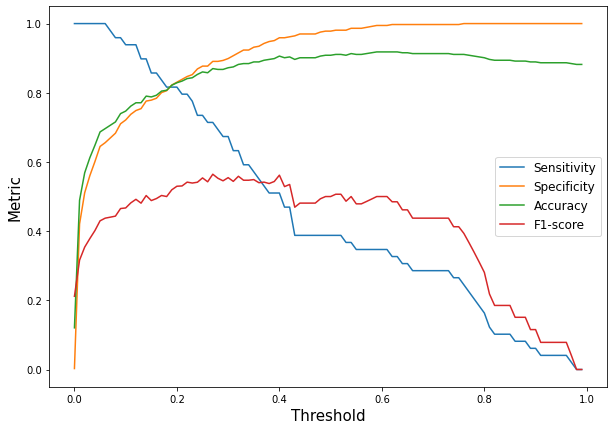

In [153]:
# Cell 15

tp, tn, fp, fn = [], [], [], []
sens, spec, acc, f1, prec = [], [], [], [], []
th = []

for threshold in range(100):
    threshold/=100
    tp.append( ((df.y_pred > threshold) & (df.y_test == 1)).sum())
    fp.append( ((df.y_pred > threshold) & (df.y_test == 0)).sum())
    tn.append( ((df.y_pred <= threshold) & (df.y_test == 0)).sum())
    fn.append( ((df.y_pred <= threshold) & (df.y_test == 1)).sum())
    sens.append(tp[-1] / (tp[-1] + fn[-1]))
    spec.append(tn[-1] / (tn[-1] + fp[-1]))
    acc.append((tp[-1] + tn[-1]) / (tp[-1] + tn[-1] + fp[-1] + fn[-1]))
    f1.append((2 * tp[-1]) / (2 * tp[-1] + fn[-1] + fp[-1]))
    prec.append(tp[-1] / (tp[-1] + fp[-1]))
    th.append(threshold)

sens = np.array(sens)
spec = np.array(spec)
prec = np.array(prec)
th = np.array(th)

plt.figure(figsize=(10,7))
plt.plot(th, sens)
plt.plot(th, spec)
plt.plot(th, acc)
plt.plot(th, f1)
plt.legend(['Sensitivity', 'Specificity', 'Accuracy', 'F1-score'], fontsize=12)
plt.xlabel('Threshold', size=15)
plt.ylabel('Metric', size=15)
plt.show()

As we increase the threshold, sensitivity decreases and specificity increases.

Accuracy and F1-score have optimum values in the middle-range for our model.

Of note, the shape of these curves may vary depending on the model and dataset.

There are two important metrics:

### Receiver Operator Characteristic (ROC) curve

The ROC curve was first used during World War II to study the ability of a radar receiver operator to correctly detect aircrafts.

The ROC curve is a plot of the discriminatory ability of a binary test across all threshold range (from 0 to 1).

The **Y axis** is the **Sensitivity**, or true positive rate, and relates to the Power of the model.

The **X axis** is **1 - Specificity**, or the false positive rate, and relates to the Type I error.

The Area Under the ROC Curve (**AUCROC**) is independent of the prevalence and independent of the threshold. It summarizes the discriminatory ability of a model.

If we randomly draw one positive case and one negative case from our testset, the probability that the score of the positive case will be greater than the score of the negative case is the **AUCROC**.

Try out to change the threshold and see that it defines a point in the ROC curve, but it doesn't change the curve itself, nor the area under it.

In [158]:
# Cell 16

slider = widgets.IntSlider(value=50, min=0.0, max=100, step=1 )
display(slider)

button = widgets.Button(description="Calculate")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    clear_output()
    threshold = slider.value / 100.
    ind = abs(th - threshold).argmin()
    roc_auc = auc(1 - spec, sens)

    plt.figure(figsize=(10, 7))
    lw = 2
    plt.plot(1 - spec, sens, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc )
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(1 - spec[ind], sens[ind], 'go--', linewidth=2, markersize=12)
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('Receiver operating characteristic curve', size=15)
    plt.legend(loc="lower right")
    plt.show()
    print("Sensitivity, or True Positive Rate, or recall: " + str(sens[ind]))
    print("Specificity, or 1 - False Positive Rate: " + str(spec[ind]))  

button.on_click(on_button_clicked)
display(button, output)

IntSlider(value=50)

Button(description='Calculate', style=ButtonStyle())

Output()

The ROC curve is all about the trade-off between sensitivity and specificity.

### Precision-Recall (PR) curve

As the name suggests, the Precision-Recall curve shows the trade-off between precision (positive predictive value) and recall (sensitivity).

As precision is dependent on the prevalence, the PR curve depends on the prevalence.

Like the area under the ROC curve, the area under the PR curve doesn't depend on the threshold.

However, each threshold defines a point in the PR curve. 

In [161]:
# Cell 16

slider = widgets.IntSlider(value=50, min=0.0, max=100, step=1 )
display(slider)

button = widgets.Button(description="Calculate")
output = widgets.Output()

def on_button_clicked(b):
  # Display the message within the output widget.
  with output:
    clear_output()
    threshold = slider.value / 100.
    ind = abs(th - threshold).argmin()
    roc_auc = average_precision_score( df.y_test, df.y_pred)

    plt.figure(figsize=(10, 7))
    lw = 2
    plt.plot(sens, prec, color='darkorange',
            lw=lw, label='PR curve (area = %0.2f)' % roc_auc )
    plt.plot(sens[ind], prec[ind], 'go--', linewidth=2, markersize=12)
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Recall', size=13)
    plt.ylabel('Precision', size=13)
    plt.title('Precision-Recall curve', size=15)
    plt.legend(loc="lower right")
    plt.show()
    print("Sensitivity, or True Positive Rate, or recall: " + str(sens[ind]))
    print("Precision, or Positive Predictive Value: " + str(prec[ind]))
    print("F1-score: " + str(f1[ind]))  

button.on_click(on_button_clicked)
display(button, output)

IntSlider(value=50)

Button(description='Calculate', style=ButtonStyle())

Output()

# Segmentation Metrics

Segmentation is the denotation of parts of an image as parts of a specific structures--eg to trace the liver in a CT image. This task demands a different metric than what is used for classification. 
A popular metric for segmentation is the Dice-Sorensen Coefficient, which is computed as 
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)
where X is the 'truth' and Y is the 'predicted' segmentation. 

In the deep learning world, we do a slight modification of this, in which we add a small number to the denominator so that in the case where an image has no pixels in the object, and the algorithm correctly also has 0 pixels, we avoid a divide by 0 error. This was described in the prior Magcian's Corner article on segmentation.

In this cell, we again define this modified dice_score, and also a dice_loss, which also is slightly different than a dice score, and which some refer to as a 'soft dice score'.

In [0]:
# Cell n 

def dice_coeff(y_true, y_pred):
    _epsilon = 10 ** -7
    im1 = np.asarray(y_true).astype(np.bool)
    im2 = np.asarray(y_pred).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return (2. * intersection.sum() + _epsilon) / (im1.sum() + im2.sum() + _epsilon)

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss



For training purposes, we will not do any segmentation, but will instead used defined images for truth and prediction so that we can easily see the impact of various conditions.
In this case, we will a function that will have 0's as background and 1's as foreground (object). The user may pass in the img_size, as well as the start and end x and y values. 

In [0]:
def create_img(img_size = 100, start_x=25, start_y=25, end_x=75, end_y=75):
    img = np.zeros((img_size, img_size), dtype = np.int16)
    if start_x < 0:
        start_x = 0
    if start_y < 0:
        start_y = 0
    if end_x > img_size:
        end_x = img_size
    if end_y > img_size:
        end_y = img_size
    img[start_x:end_x + 1, start_y:end_y + 1] = 1
    return img


In [0]:
# Cell n
# Compute Hausdorf, which is the distance/error of one edge to another
# code taken from: https://github.com/sapphire008/Python/blob/master/generic/HausdorffDistance.py

from numpy.core.umath_tests import inner1d

def HausdorffDist(A,B):
    # The Hausdorff distance between A and B, denoted by dH(A,B),
    # is defined by:
    # dH(A,B) = max(h(A,B),h(B,A)),
    # where h(A,B) = max(min(d(a,b))
    # and d(a,b) is a L2 norm
    # dist_H = hausdorff(A,B)
    #
    # Edward DongBo Cui; Stanford University; 06/17/2014

    # Find pairwise distance
    D_mat = np.sqrt(inner1d(A,A)[np.newaxis].T + inner1d(B,B)-2*(np.dot(A,B.T)))
    # Find DH
    dH = np.max(np.array([np.max(np.min(D_mat,axis=0)),np.max(np.min(D_mat,axis=1))]))
    return(dH)

def ModHausdorffDist(A,B):
    #This function computes the Modified Hausdorff Distance (MHD) which is
    #proven to function better than the directed HD as per Dubuisson et al.
    #in the following work:
    #
    #M. P. Dubuisson and A. K. Jain. A Modified Hausdorff distance for object
    #matching. In ICPR94, pages A:566-568, Jerusalem, Israel, 1994.
    #http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=576361
    #
    #The function computes the forward and reverse distances and outputs the
    #maximum/minimum of both.
    #Optionally, the function can return forward and reverse distance.
    #
    #Edward DongBo Cui Stanford University; 06/17/2014

    # Find pairwise distance
    D_mat = np.sqrt(inner1d(A,A)[np.newaxis].T + inner1d(B,B)-2*(np.dot(A,B.T)))
    # Calculating the forward HD: mean(min(each col))
    FHD = np.mean(np.min(D_mat,axis=1))
    # Calculating the reverse HD: mean(min(each row))
    RHD = np.mean(np.min(D_mat,axis=0))
    # Calculating mhd
    MHD = np.max(np.array([FHD, RHD]))
    return(MHD, FHD, RHD)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  """


In [0]:
SIZE = 100
truth = create_img (img_size = SIZE, start_x=25, start_y = 25, end_x = 75, end_y = 75)
pred = create_img (img_size = SIZE, start_x=25, start_y = 25, end_x = 76, end_y = 72)

dsc = dice_coeff(truth, pred)
loss = dice_loss (truth, pred)
hd = HausdorffDist(truth, pred)
mhd = ModHausdorffDist(truth, pred)
print ("DSC is " + str(dsc) + ", loss is " + str(loss) + ", Hausdorf = " + str(hd) + ", Modified Hausdorf = " + str(mhd))


DSC is 0.9605650382585724, loss is 0.03943496174142758, Hausdorf = 1.7320508075688772, Modified Hausdorf = (0.9006664199358161, 0.8833459118601273, 0.9006664199358161)


What about Regression metrics? And image-mapping metrics?